# **Puzzle Pals Functions**

NOTE: cv2.imshow does not work on collab, use cv2_imshow instead

In [ ]:
import cv2
import imutils
from imutils import paths
import argparse
import matplotlib.pyplot as plt
import numpy as np
import math
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Edge Piece Detection

In [ ]:
def is_edge_piece(piece):
  piece = piece[:, 10:piece.shape[1]-10]
  gray = cv2.cvtColor(piece, cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(gray, 50, 150, apertureSize=3)
  #minLineLength = edge_piece.shape[1] - 300
  minLineLength = 80
  lines = cv2.HoughLinesP(image=edges, rho=0.02, theta=np.pi / 500, threshold=10, lines=np.array([]), minLineLength=minLineLength, maxLineGap=2)
  if lines is not None:
    return True
  else:
    return False

In [ ]:
edge_piece = cv2.imread('/content/drive/MyDrive/EECS 441/Google Collab/imgs/kaia_pics/edge_piece.jpg')
kevin_piece = cv2.imread('/content/drive/MyDrive/EECS 441/Google Collab/imgs/kaia_pics/red_piece_result.png')

print(is_edge_piece(edge_piece))
print(is_edge_piece(kevin_piece))

True
False


# Blurry Check

In [ ]:
def is_blurry(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    if laplacian_var < 60:
        return True
    else:
        return False

In [ ]:
def is_too_homogenous(img, bg_color):
  # Given an average background color from avg_background_color, returns true if the whole image is too similar and a piece cannot be distinguished.
  error = True
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if not is_background(img[i, j], bg_color):
        error = False
  return error

In [ ]:
blurry_pic = cv2.imread('/content/drive/MyDrive/EECS 441/Google Collab/imgs/kaia_pics/blurry.jpg')

if is_blurry(blurry_pic):
    print("The image is blurry")
else:
    print("The image is not blurry")

if is_blurry(kevin_piece):
    print("The image is blurry")
else:
    print("The image is not blurry")

The image is blurry
The image is not blurry


# Bg Removal + Crop

In [ ]:
def crop(img):
  # Convert the color image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Threshold the grayscale image to create a binary image
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Find contours in the binary image
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Get the bounding box of the contour with the largest area
  largest_contour = max(contours, key=cv2.contourArea)
  x, y, w, h = cv2.boundingRect(largest_contour)

  # Calculate the aspect ratio of the bounding box
  aspect_ratio = w / h

  # Determine the minimum crop size
  if aspect_ratio > 1:
      crop_size = h
  else:
      crop_size = w

  # Calculate the center of the bounding box
  center_x = x + w // 2
  center_y = y + h // 2

  # Calculate the new bounding box coordinates
  new_x = center_x - crop_size // 2
  new_y = center_y - crop_size // 2
  new_w = crop_size
  new_h = crop_size

  # Crop the image
  crop_img = img[new_y:new_y+new_h, new_x:new_x+new_w]

  return crop_img

In [ ]:
def avg_background_color(piece):
  b = 0
  g = 0
  r = 0
  # piece.shape[0] is the height, piece.shape[1] is the width
  for i in range(piece.shape[0]):
    b += piece[0, i][0]
    g += piece[0, i][1]
    r += piece[0, i][2] 
  b /= piece.shape[0]
  g /= piece.shape[0]
  r /= piece.shape[0]
  return (b, g, r)

In [ ]:
def is_background(pixel, bg_color):
  # pixel will be an ndarray of 3 elements
  # bg_color gotten from above function
  # See if pixel BGR is within 5% of bg_color
  poss_error = 255*.1
  # RMS
  rms_error = math.sqrt(((pixel[0] - bg_color[0])**2 + (pixel[1] - bg_color[1])**2 + (pixel[2] - bg_color[2])**2)/2)
  return rms_error < poss_error

In [ ]:
def greedy_rectangle(img, bg_color):
  # Remember that y coord is first for ndarrays for some reason
  top = img.shape[0] - 1
  bottom = 0
  left = 0
  right = img.shape[1] - 1
  done = False
  while not done:
    top_bg_ct = 0
    bottom_bg_ct = 0
    left_bg_ct = 0
    right_bg_ct = 0
    #FIXME: 4 for loops that go through the current edges of the box, trawling for background pixels
    for i in range(left, right):
      # top left to top right
      # bottom left to bottom right
      if is_background(img[top, i], bg_color):
        top_bg_ct += 1
      if is_background(img[bottom, i], bg_color):
        bottom_bg_ct += 1
    for j in range(bottom, top):
      # bottom left to top left 
      # bottom right to top right
      if is_background(img[j, left], bg_color):
        left_bg_ct += 1
      if is_background(img[j, right], bg_color):
        right_bg_ct += 1
    if (top_bg_ct == 0 and bottom_bg_ct == 0
        and left_bg_ct == 0 and right_bg_ct == 0):
      done = True
    else:
      # shrink side that has the least non-background pixels
      max_bg = max(top_bg_ct, bottom_bg_ct, left_bg_ct, right_bg_ct)
      if max_bg == top_bg_ct:
        top -= 1
      elif max_bg == bottom_bg_ct:
        bottom += 1
      elif max_bg == left_bg_ct:
        left += 1
      elif max_bg == right_bg_ct:
        right -= 1
  return img[bottom:top, left:right]

False
False


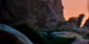

In [ ]:
sunrise_puzzle = cv2.imread('/content/drive/MyDrive/EECS 441/Google Collab/imgs/kaia_pics/beachsunrisepuzzle.jpg')
sunrise_piece = cv2.imread('/content/drive/MyDrive/EECS 441/Google Collab/imgs/kaia_pics/mostlyrock.png')
# Demonstrating not triggering popups, #1:
print(is_blurry(sunrise_piece))
bg_color = avg_background_color(sunrise_piece)
# Demonstrating not triggering popups, #2:
print(is_too_homogenous(sunrise_piece, bg_color))
outer_bounding_box = crop(sunrise_piece)
cropped_rect = greedy_rectangle(sunrise_piece, bg_color)
cv2_imshow(cropped_rect)

#  Find match

In [ ]:
def temp_match_rescale(full_puzzle, puzzle_piece, difficulty):
  # Don't convert the images to grayscale
  full_puzzle_gray = full_puzzle
  # cv2.cvtColor(full_puzzle, cv2.COLOR_BGR2GRAY)
  puzzle_piece_gray = puzzle_piece
  # cv2.cvtColor(puzzle_piece, cv2.COLOR_BGR2GRAY)

  # Bookkeeping variable to find best fit
  found = None
  # Template/piece height and width 
  tH = None
  tW = None

  # Apply template matching to find the puzzle piece location in the full puzzle image
  for scale in np.linspace(0.1, 1.0, 20)[::-1]:
    # Resize puzzle piece image and keep ratio of resizing
    resizey = imutils.resize(puzzle_piece_gray, width = int(puzzle_piece_gray.shape[1] * scale))
    r = puzzle_piece_gray.shape[1] / float(resizey.shape[1])
    res = cv2.matchTemplate(full_puzzle_gray, puzzle_piece_gray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # max_val keeps track of the maximum correlative area
    # if we have found a new maximum correlation value, then update
		# the bookkeeping variable
    if found is None or max_val > found[0]:
      found = (max_val, max_loc, r)
      (tH, tW) = resizey.shape[:2]

  # Draw a rectangle around the puzzle piece location in the full puzzle image, getting location from stored found var
  # unpack the bookkeeping variable and compute the (x, y) coordinates
	# of the bounding box based on the resized ratio
  (_, maxLoc, r) = found
  (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
  (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
  
  # draw a bounding box around the detected result and display the image
  cx = startX + endX //2
  cy = startY + endY //2
  #cv2.rectangle(full_puzzle, (startX, startY), (endX, endY), (0, 0, 255), 2)
  x_coord = startX + int((endX - startX) / 2)
  y_coord = startY + int((endY - startY) / 2)
  if difficulty == 'easy':
    cv2.circle(full_puzzle, (x_coord, y_coord), 40, (0, 255, 255), 2)
  else:
    cv2.circle(full_puzzle, (x_coord, y_coord), 80, (0, 255, 255), 2)

  # Display the result
  cv2_imshow(full_puzzle)

  return full_puzzle
  # FIXME: Write image to file or table here.

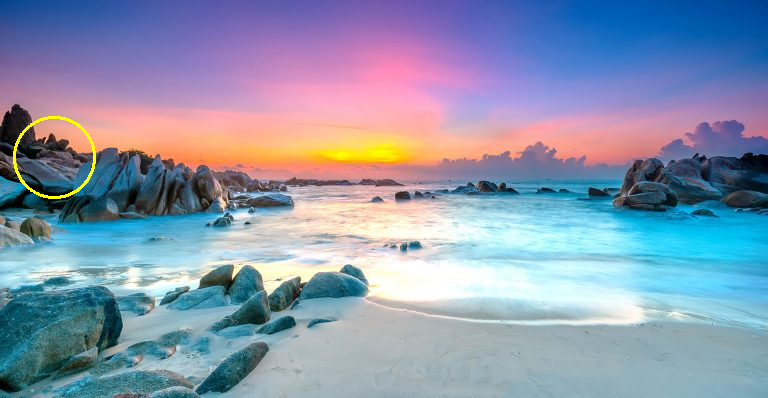

array([[[138,  67,   4],
        [138,  67,   4],
        [138,  67,   4],
        ...,
        [144,  64,   1],
        [144,  63,   2],
        [144,  63,   2]],

       [[138,  67,   4],
        [138,  67,   4],
        [138,  67,   4],
        ...,
        [144,  64,   1],
        [144,  63,   2],
        [144,  63,   2]],

       [[139,  68,   5],
        [139,  68,   5],
        [139,  68,   5],
        ...,
        [143,  63,   0],
        [143,  63,   0],
        [143,  63,   0]],

       ...,

       [[120, 106,  30],
        [150, 137,  59],
        [128, 115,  37],
        ...,
        [180, 161, 116],
        [179, 160, 115],
        [179, 160, 115]],

       [[119, 104,  35],
        [119, 105,  33],
        [104,  91,  17],
        ...,
        [180, 161, 116],
        [179, 160, 115],
        [179, 160, 115]],

       [[112,  99,  31],
        [ 98,  86,  16],
        [102,  90,  20],
        ...,
        [180, 161, 116],
        [179, 160, 115],
        [179, 160, 115]]

In [ ]:
temp_match_rescale(sunrise_puzzle, cropped_rect, 'easy')